In [43]:
###### IMPORTING RELEVANT LIBRARIES 

import os
import numpy as np
import pandas as pd
import seaborn as sns
import pyspark

#from IPython.core.display import display, HTML
#from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

In [44]:
#Import data
spark = SparkSession.builder.getOrCreate()

df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('season_totals.csv')

df_2 = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('next_years.csv')

In [45]:
#identify last year and first year for the data sets, this value will be used as union point later
df.select(pyspark.sql.functions.max(df.yr)).show()
df_2.select(pyspark.sql.functions.min(df_2.yr)).show()

#checking columns consistency
col_1 = []
col_2 = []

temp1 = df.schema
for item in temp1:
    col_1.append(str(item))


temp2 = df_2.schema
for item in temp2:
    col_2.append(str(item))

print(len(col_1))
print(len(col_2))

#column _c0 will be deleted from the first dataset
test_set = set(col_1) - set(col_2)
test_set


+-------+
|max(yr)|
+-------+
|   2016|
+-------+

+-------+
|min(yr)|
+-------+
|   2010|
+-------+

31
30


{"StructField('_c0', IntegerType(), True)"}

In [46]:
#Union 2 data sets after dropping '_c0' column
df = df.drop('_c0')
df.createOrReplaceTempView('df')

temp_df = spark.sql('''
    SELECT *
    FROM df
    ''')

df_2.createOrReplaceTempView('df_2')

next_years = spark.sql(
        '''
        SELECT
            *
        FROM df_2
        WHERE yr > 2016
        
        ''')

df_total = df.union(next_years)

In [47]:
#test if null values in the relevant columns
df_total.createOrReplaceTempView('df_total')

spark.sql('''
    SELECT
        *
    FROM df_total
    WHERE yr IS NULL
    or team_id IS NULL
    or fg3a IS NULL
    or fg2a IS NULL
    or mp IS NULL
''').show()

+------+---+---+-------+---+---+---+---+---+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+---+---+
|player|pos|age|team_id|  g| gs| mp| fg|fga|fg_pct|fg3|fg3a|fg3_pct|fg2|fg2a|fg2_pct|efg_pct| ft|fta|ft_pct|orb|drb|trb|ast|stl|blk|tov| pf|pts| yr|
+------+---+---+-------+---+---+---+---+---+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+---+---+
+------+---+---+-------+---+---+---+---+---+------+---+----+-------+---+----+-------+-------+---+---+------+---+---+---+---+---+---+---+---+---+---+



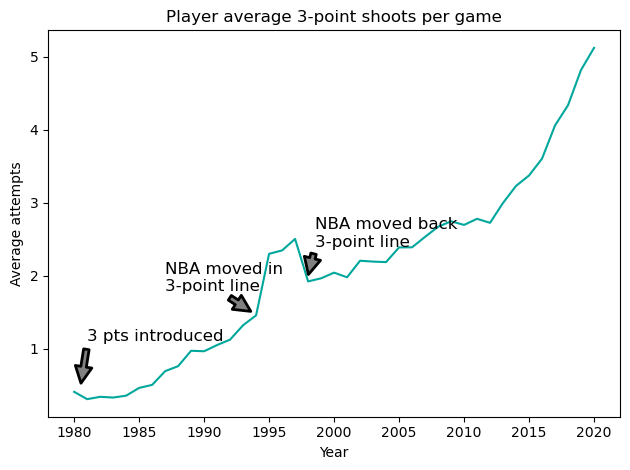

In [48]:
#Historical trend
fga_py = spark.sql('''SELECT 
                        yr,
                        sum(fg3a)/sum(mp)*36 as fg3a_p36m
                      FROM df_total 
                      GROUP BY yr
                      ORDER BY yr''')

df_plot = fga_py.toPandas()
plt.plot(df_plot.yr,df_plot.fg3a_p36m, color = '#00a79c')
plt.xlabel('Year')
plt.ylabel('Average attempts')
_=plt.title('Player average 3-point shoots per game')
_=plt.annotate('3 pts introduced', xy=(1980.5, .5), xytext=(1981, 1.1), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved in\n3-point line', xy=(1993.7, 1.5), xytext=(1987, 1.79), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))

plt.tight_layout()
plt.savefig('3_point_trend.png')

In [49]:
#3 points attemps trend
fga_py.createOrReplaceTempView('fga_py')

#Splitting into train and test subset: I'm using the coefficients from training set to plot expected linear trend
#after year 2015
fga_py_train = spark.sql('''SELECT 
                        *
                      FROM fga_py 
                      WHERE yr <= 2015''')


fga_py_test = spark.sql('''SELECT 
                        *
                      FROM fga_py 
                      WHERE yr > 2015''')

#creating fetures and label columns that will be used in the model
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')

training = t.transform(fga_py_train)\
            .withColumn('yr',fga_py_train.yr)\
            .withColumn('label',fga_py_train.fg3a_p36m)

training.toPandas().head()

,yr,fg3a_p36m,features,label
0,1980,0.410089,[1980.0],0.410089
1,1981,0.309376,[1981.0],0.309376
2,1982,0.341511,[1982.0],0.341511
3,1983,0.331479,[1983.0],0.331479
4,1984,0.357110,[1984.0],0.357110


23/07/07 17:14:10 WARN Instrumentation: [59e313c3] regParam is zero, which might cause numerical instability and overfitting.


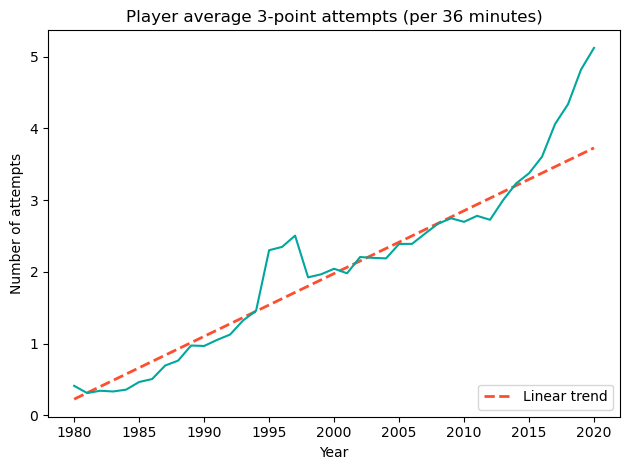

In [50]:
#model fit
lin_regression = LinearRegression(maxIter=20)
train_model = lin_regression.fit(training)

#Apply the model
test = t.transform(fga_py_test)\
            .withColumn('yr',fga_py_test.yr)\
            .withColumn('label',fga_py_test.fg3a_p36m)

df_test = train_model.transform(test).toPandas()

df_train = train_model.transform(training).toPandas()

df_all_year = pd.concat([df_train, df_test])

#plotting the trend
plt.plot(df_all_year.yr,df_all_year.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'Linear trend')
plt.plot(df_all_year.yr, df_all_year.fg3a_p36m, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()

plt.savefig('3_point_linear_trend.png')

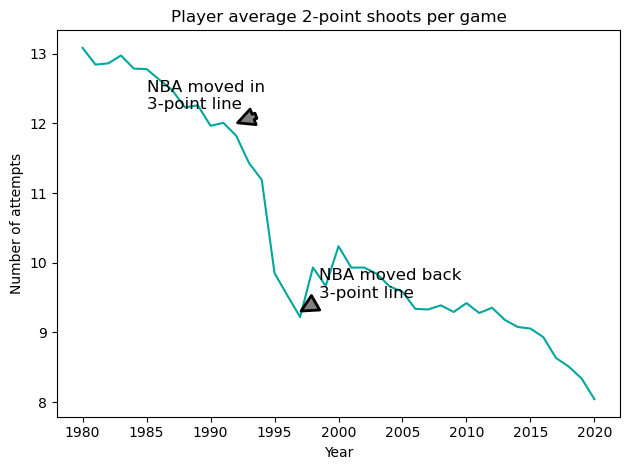

In [51]:
#repeating the exercise for 2 points attempts
fga_2pt_py = spark.sql('''SELECT 
                        yr,
                        sum(fg2a)/sum(mp)*36 as fg2a_p36m
                      FROM df_total 
                      GROUP BY yr
                      ORDER BY yr''')

df_2pt_plot = fga_2pt_py.toPandas()
plt.plot(df_2pt_plot.yr,df_2pt_plot.fg2a_p36m, color = '#00a79c')
plt.xlabel('Year')
plt.ylabel('Number of attempts')
_=plt.title('Player average 2-point shoots per game')
_=plt.annotate('NBA moved in\n3-point line', xy=(1992, 12), xytext=(1985, 12.2), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved back\n3-point line', xy=(1997, 9.3), xytext=(1998.5, 9.5), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.tight_layout()
plt.savefig('2_point_trend.png')

23/07/07 17:14:37 WARN Instrumentation: [25baf7a7] regParam is zero, which might cause numerical instability and overfitting.


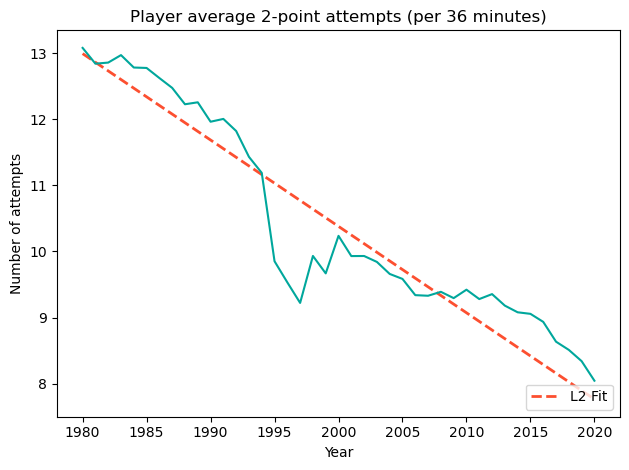

In [52]:
#2 points attemps trend
fga_2pt_py.createOrReplaceTempView('fga_2pt_py')

#Splitting into train and test subset
fga_2pt_py_train = spark.sql('''SELECT 
                        *
                      FROM fga_2pt_py 
                      WHERE yr <= 2015''')


fga_2pt_py_test = spark.sql('''SELECT 
                        *
                      FROM fga_2pt_py 
                      WHERE yr > 2015''')

#creating fetures and label columns that will be used in our model
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')

training = t.transform(fga_2pt_py_train)\
            .withColumn('yr',fga_2pt_py_train.yr)\
            .withColumn('label',fga_2pt_py_train.fg2a_p36m)


#creating fetures and label columns that will be used in our model

#model fit
lin_regress = LinearRegression(maxIter=20)
train_model = lin_regress.fit(training)


test = t.transform(fga_2pt_py_test)\
            .withColumn('yr',fga_2pt_py_test.yr)\
            .withColumn('label',fga_2pt_py_test.fg2a_p36m)


df_test_2pt = train_model.transform(test).toPandas()
df_train_2pt = train_model.transform(training).toPandas()

df_all_year_2pt = pd.concat([df_train_2pt, df_test_2pt])

plt.plot(df_all_year_2pt.yr,df_all_year_2pt.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(df_all_year_2pt.yr, df_all_year_2pt.fg2a_p36m, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 2-point attempts (per 36 minutes)')
plt.tight_layout()

In [53]:
#Next Step: does the 3 points shooting increase your winning chances?
team_3pt_rank = spark.sql('''WITH a as (
                        SELECT 
                            yr,
                            team_id,
                            sum(fg3a)/sum(mp)*36 as fg3a_p36m
                      FROM df_total 
                      GROUP BY 1,2
                      ORDER BY 1,2)
                      
                      SELECT
                          b.*
                      FROM (
                          SELECT
                          *,
                          row_number() over (partition by yr order by fg3a_p36m DESC) as rank_3pt
                          FROM a) b
                      ''')

df_teams = team_3pt_rank.toPandas()

In [54]:
#in 2017 Houston had the best recordo in regular season and it was also the team with the highest 3pts average attempt
#it looks like shooting from the distance is highly related with winning
df_teams[df_teams['yr'] == 2017]

,yr,team_id,fg3a_p36m,rank_3pt
1051,2017,HOU,6.016683,1
1052,2017,CLE,5.032141,2
1053,2017,BOS,4.997064,3
1054,2017,BRK,4.721879,4
1055,2017,GSW,4.662892,5
1056,2017,DAL,4.500910,6
1057,2017,PHI,4.434875,7
1058,2017,TOT,4.428729,8
1059,2017,DEN,4.309577,9
1060,2017,CHO,4.261032,10


In [55]:
#we should investigate now the correlation between winning records and 3pts attempts. To do so, i'm relying on another
#data set with teams statistics around win/lose records
spark = SparkSession.builder.getOrCreate()

df_record = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('teams_record_full.csv')


In [56]:
#let's calculate winning ratio and drop year 2022 (not included in the other shooting dataset)
df_record.createOrReplaceTempView('df_record')

df_rr = spark.sql('''
        With start_data as (
        SELECT
            yr,
            TEAM_ID as team_id,
            W/L as perc_win
        FROM df_record
        WHERE yr not in (2022))
        
        SELECT 
            a.*
        FROM (
             SELECT *,
             row_number() over (partition by yr ORDER BY perc_win DESC) as final_rank
             FROM start_data) a
''')

df_rr.show()

+----+-------+------------------+----------+
|  yr|team_id|          perc_win|final_rank|
+----+-------+------------------+----------+
|1980|    BOS|               3.1|         1|
|1980|    PHI|               3.1|         2|
|1980|    MIL| 2.727272727272727|         3|
|1980|    PHO|              2.28|         4|
|1980|    LAL|1.9285714285714286|         5|
|1980|    SAS|1.7333333333333334|         6|
|1980|    NYK|            1.5625|         7|
|1980|    CHI|1.2162162162162162|         8|
|1980|    POR|1.2162162162162162|         9|
|1980|    IND|1.1578947368421053|        10|
|1980|    HOU|0.9523809523809523|        11|
|1980|    SAC|0.9523809523809523|        12|
|1980|    GSW|0.9069767441860465|        13|
|1980|    WAS|0.9069767441860465|        14|
|1980|    DEN|0.8222222222222222|        15|
|1980|    LAC| 0.782608695652174|        16|
|1980|    OKC|0.7083333333333334|        17|
|1980|    ATL|0.6078431372549019|        18|
|1980|    CLE|0.5185185185185185|        19|
|1980|    

In [14]:
df_rr.createOrReplaceTempView('df_rr')
team_3pt_rank.createOrReplaceTempView('team_3pt_rank')

df_final = spark.sql('''
        SELECT
            dr.*,
            t3p.rank_3pt,
            t3p.fg3a_p36m
        FROM df_rr dr
        LEFT JOIN team_3pt_rank t3p
            ON dr.yr = t3p.yr
            AND dr.team_id = t3p.team_id
            ''')

df_final.show()

+----+-------+------------------+----------+--------+-------------------+
|  yr|team_id|          perc_win|final_rank|rank_3pt|          fg3a_p36m|
+----+-------+------------------+----------+--------+-------------------+
|1980|    BOS|               3.1|         1|       2|  0.764185110663984|
|1980|    PHI|               3.1|         2|      19|0.22664316293125158|
|1980|    MIL| 2.727272727272727|         3|      17| 0.2817470335773794|
|1980|    PHO|              2.28|         4|       6|  0.510250569476082|
|1980|    LAL|1.9285714285714286|         5|      22|0.18108651911468812|
|1980|    SAS|1.7333333333333334|         6|      12| 0.3753986332574032|
|1980|    NYK|            1.5625|         7|      13|  0.347623862487361|
|1980|    CHI|1.2162162162162162|         8|       7|0.49736247174076864|
|1980|    POR|1.2162162162162162|         9|      18|0.24024266936299293|
|1980|    IND|1.1578947368421053|        10|       4| 0.5710244493837138|
|1980|    HOU|0.9523809523809523|     

In [57]:
stat_df = df_final.toPandas()
stat_df[stat_df['fg3a_p36m'].isnull()]

,yr,team_id,perc_win,final_rank,rank_3pt,fg3a_p36m
11,1980,SAC,0.952381,12,NaN,NaN
13,1980,WAS,0.906977,14,NaN,NaN
15,1980,LAC,0.782609,16,NaN,NaN
16,1980,OKC,0.708333,17,NaN,NaN
20,1980,BRK,0.413793,21,NaN,NaN
...,...,...,...,...,...,...
1167,2021,IND,0.438596,26,NaN,NaN
1168,2021,OKC,0.413793,27,NaN,NaN
1169,2021,DET,0.389831,28,NaN,NaN
1170,2021,ORL,0.366667,29,NaN,NaN


In [58]:
#get rid of null values
stat_df_clean = stat_df.dropna()

In [59]:
#let's calculate the correlation between 3pts attempts and winning percentage, grouping by year.
#unstack and iloc used to select the relevant series
res = stat_df_clean.groupby('yr')[['perc_win','fg3a_p36m']].corr().unstack().iloc[:,1]

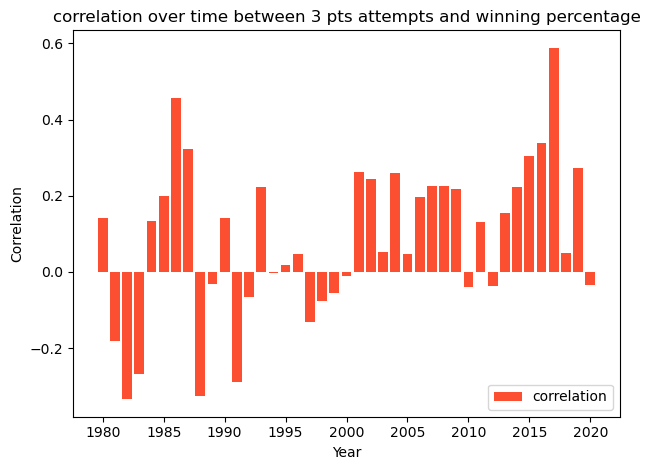

In [60]:
#plot the result: apparently 2017 was a particular year where correlation between win% and 3pts attemps has been
#particularly high. The same it's not always true in the other years.
plt.bar(res.index,res, linewidth = 2, linestyle = '--',color = '#fc4f31', label = 'correlation')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.legend(loc = 4)
_=plt.title('correlation over time between 3 pts attempts and winning percentage')
plt.tight_layout()